MERABET Mohamed Malih 22202729, 
MESSAOUDI Nor El Houda 22216866, 
SEOUDI Noha 21813399, 
ZEDDAM Lylia 21812374

# **Importer les librairies nécessaires**

---



In [ ]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras_preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import PIL
import matplotlib.pyplot as plt
from PIL import Image
from numpy import asarray
import random
from sklearn.model_selection import StratifiedKFold,train_test_split
from keras.preprocessing.image import ImageDataGenerator
import sklearn
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras import backend as K
from keras.layers import Reshape, Conv2DTranspose
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

## **Installation des libraire et mise en palce de google drive**

In [ ]:
!pip install pyyaml h5py #pour sauvegarder le modèle 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# pour monter son Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import sys 
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/M2_ML_Projet'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

/content/gdrive/My Drive/Colab Notebooks/M2_ML_Projet


'/content/gdrive/My Drive/Colab Notebooks/M2_ML_Projet'

In [ ]:
#pour télécharger le zip file 
!wget https://www.lirmm.fr/~poncelet/Ressources/Tiger-Fox-Elephant.zip

--2022-12-06 08:27:45--  https://www.lirmm.fr/~poncelet/Ressources/Tiger-Fox-Elephant.zip
Resolving www.lirmm.fr (www.lirmm.fr)... 193.49.104.251
Connecting to www.lirmm.fr (www.lirmm.fr)|193.49.104.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7605545 (7.3M) [application/zip]
Saving to: ‘Tiger-Fox-Elephant.zip.14’

Tiger-Fox-Elephant. 100%[===================>]   7.25M  7.02MB/s    in 1.0s    

2022-12-06 08:27:47 (7.02 MB/s) - ‘Tiger-Fox-Elephant.zip.14’ saved [7605545/7605545]



In [ ]:
import zipfile
with zipfile.ZipFile("Tiger-Fox-Elephant.zip","r") as zip_ref:
    zip_ref.extractall("Data_Project")

# **Définition de quelques fonctions utiles**

---



In [ ]:
# Pour trier les fichiers en ordre alphabétique
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

In [ ]:
def create_training_data(path_data, list_classes):  
  training_data=[]   #Tableau de retour 
  for classes in list_classes: # tiger et tiger_negative
      path = os.path.join(path_data, classes)
      class_num = list_classes.index(classes)
      for img in os.listdir(path):
        try:
          img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_UNCHANGED)
          new_array = cv2.resize(img_array, (SIZE,SIZE))  
          training_data.append([new_array, class_num])  # on remplit notre tableau 
        except Exception as e:
          pass  
  return training_data 

In [ ]:
def create_X_y (path_data, list_classes):
      # récupération des données
      training_data = create_training_data(path_data, list_classes)
      # tri des données
      random.shuffle(training_data)
      # création de X et y
      X=[]
      y=[]
      for features, label in training_data:
        X.append(features)
        y.append(label)
      X=np.array(X).reshape(-1,SIZE, SIZE, 3)  #-1 The new shape should be compatible with the original shape.  
      y=np.array(y)
      return X,y  

In [ ]:
def clean_data(x): 
  # convertion d'entier en float
  xtrain_norm = x.astype('float32')
  # normalisation entre 0 et 1
  xtrain_norm = xtrain_norm / 255.0
  return xtrain_norm

# **Préparation des données**

---



In [ ]:
SIZE = 128
color_img = []
gray_img = []

#Les chemins vers les dossier de données
path = 'Data_Project/Tiger-Fox-Elephant/tiger'
path2 = 'Data_Project/Tiger-Fox-Elephant/elephant'
path3 = 'Data_Project/Tiger-Fox-Elephant/fox'
files = os.listdir(path)
files = sorted_alphanumeric(files)

files2 = os.listdir(path2)
files2 = sorted_alphanumeric(files2)

files3 = os.listdir(path3)
files3 = sorted_alphanumeric(files3)

#Remplir les tableau color_img et gray_img
for i in tqdm(files):   
  img = PIL.Image.open(path + '/'+i)
    #Transformation de l'image en grayscale
  imgGray = img.convert("L")
    #Redimensionner l'image en couleur
  img = img.resize((SIZE, SIZE))
  img = np.float32(img) / 255.0
  color_img.append(img_to_array(img))
    #Redimensionner l'image en noir et blanc
  imgGray = imgGray.resize((SIZE, SIZE))
  imgGray = np.float32(imgGray)  / 255.0
  gray_img.append(np.squeeze(img_to_array(imgGray)))



for i in tqdm(files2):   
  img = PIL.Image.open(path2 + '/'+i)
  imgGray = img.convert("L")
  img = img.resize((SIZE, SIZE))
  img = np.float32(img) / 255.0
  color_img.append(img_to_array(img))
  
  imgGray = imgGray.resize((SIZE, SIZE))
  imgGray = np.float32(imgGray)  / 255.0
  gray_img.append(np.squeeze(img_to_array(imgGray)))




for i in tqdm(files3):   
  img = PIL.Image.open(path3 + '/'+i)
  imgGray = img.convert("L")
  img = img.resize((SIZE, SIZE))
  img = np.float32(img) / 255.0
  color_img.append(img_to_array(img))
  
  imgGray = imgGray.resize((SIZE, SIZE))
  imgGray = np.float32(imgGray)  / 255.0
  gray_img.append(np.squeeze(img_to_array(imgGray)))
  

100%|██████████| 100/100 [00:19<00:00,  5.25it/s]


In [ ]:
my_path = "Data_Project/Tiger-Fox-Elephant/"
my_classes = ['tiger','Tiger_negative_class']
batchSize = 32


#Generation de donnée
def addGenerateddata(Xbatch):
 for i in range (batchSize):
   Xbatch[i] = cv2.cvtColor(Xbatch[i], cv2.COLOR_BGR2RGB)
   imgGray = cv2.cvtColor(Xbatch[i], cv2.COLOR_BGR2GRAY)
   color_img.append(img_to_array(Xbatch[i]))
   gray_img.append(np.squeeze(img_to_array(imgGray)))



X, y = create_X_y(my_path, my_classes) # load dataset
X = clean_data(X)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True) 

y_train.shape = (y_train.shape[0],1)
y_test.shape = (y_test.shape[0],1)

datagen = ImageDataGenerator(width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               rotation_range=5,
                               fill_mode='nearest')
train_iterator = datagen.flow(X_train, y_train, batch_size= batchSize, shuffle=False, save_prefix='augmente_train')#,subset='training')#save_to_dir='./idgTrain', save_prefix='augmente_train', 
loop=0
for X_batch, y_batch in train_iterator: #permet de charger des lots de données
    loop=loop+1
    print('data batch shape:',X_batch.shape)
    print('labels batch shape:',y_batch.shape)
    addGenerateddata(X_batch)
    #on sort de la boucle après atteindre un certain seuil de nombre d'images 
    if(len(color_img)>8000) : break

data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labe

In [ ]:
#Nous avons mis les images dans un ordre aléatoire pour mieux entraîner le modèle
color_img,gray_img = sklearn.utils.shuffle(color_img,gray_img)

In [ ]:
#Nombre totale de données 
len(color_img)

8012

# **Affichage de l'image en couleur et son image noir et blanc correspondante**

In [ ]:
# Affichage d'images
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Image en couleur', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Image en noir et blanc', color = 'black', fontsize = 20)
    plt.imshow(grayscale, cmap='gray')
   
    plt.show()

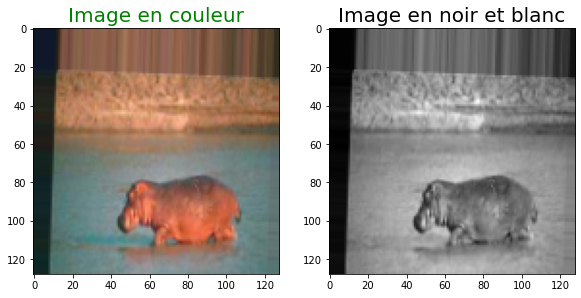

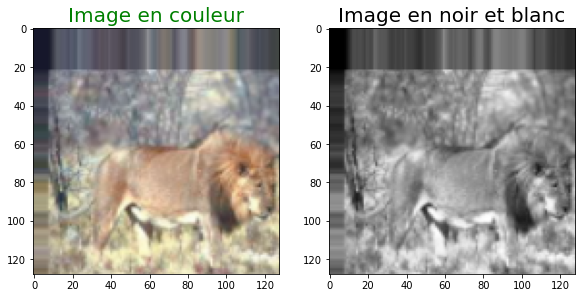

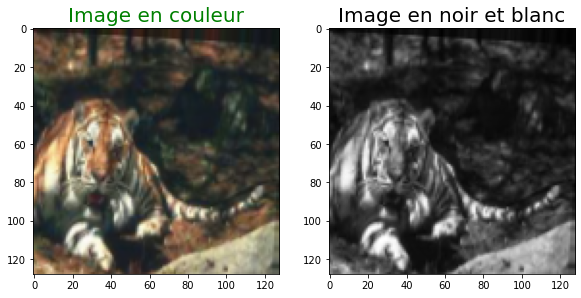

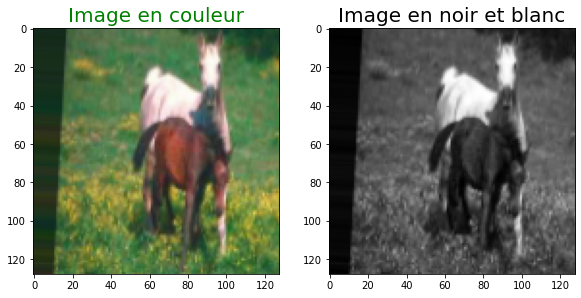

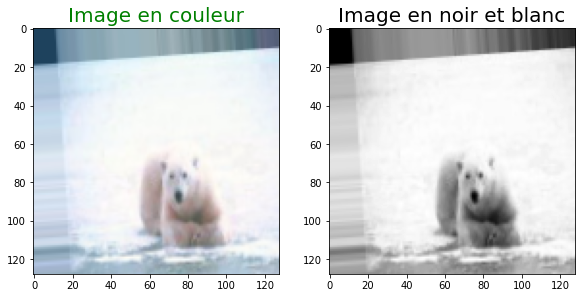

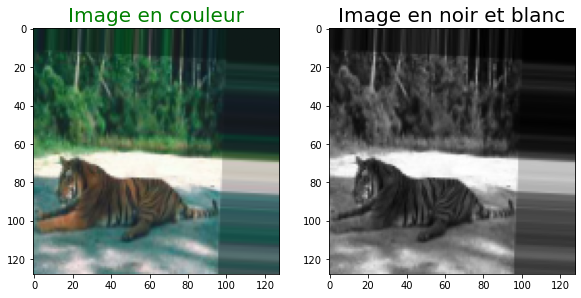

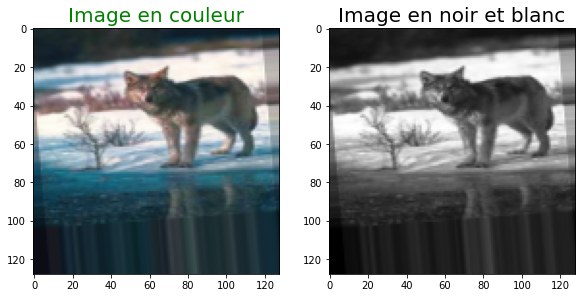

In [ ]:
#Affichage de 7 image aléatoire
for i in range(3,10):
   plot_images(color_img[i],gray_img[i])

In [ ]:
#On divise l'ensemble de données entre les tableaux d'entraînement et de test

train_gray_image = gray_img[20:]
train_color_image = color_img[20:]

test_gray_image = gray_img[:20]
test_color_image = color_img[:20]
# reshaping
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,1))

train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print("la forme de l'image en couleur(entrainement):",train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,1))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print("la forme de l'image noir et blanc (entrainement):",test_color_image.shape)



la forme de l'image en couleur(entrainement): (7992, 128, 128, 3)
la forme de l'image noir et blanc (entrainement): (20, 128, 128, 3)


**Hyperparamètres**

In [ ]:
input_shape = (SIZE, SIZE,1)
tailleBatch = 48
kernel_size = 3
latent_dim = 256
nb_epochs=30

# **Modèle encodeur**

In [ ]:
layer_filters = [64, 128, 256]

inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# pile de Conv2D(64)-Conv2D(128)-Conv2D(256)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# informations de forme nécessaires pour construire le modèle de décodeur 
#afin que nous ne fassions pas de calcul manuel
shape = K.int_shape(x)
# générer un vecteur latent
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# modèle d'encodeur instancié
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 latent_vector (Dense)       (None, 256)               16777472  
                                                                 
Total params: 17,147,136
Trainable params: 17,147,136
Non-t

In [ ]:
# construire le modèle de décodeur
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Pile de Conv2DTranspose(256)-Conv2DTranspose(128)-Conv2DTranspose(64)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# modèle de décodeur instancié
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 65536)             16842752  
                                                                 
 reshape (Reshape)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 128, 128, 64)     7379

In [ ]:
# modèle de Autoencodeur instancié
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 1)]     0         
                                                                 
 encoder (Functional)        (None, 256)               17147136  
                                                                 
 decoder (Functional)        (None, 128, 128, 3)       17803395  
                                                                 
Total params: 34,950,531
Trainable params: 34,950,531
Non-trainable params: 0
_________________________________________________________________


# **Engregistré le modèle**

---



In [ ]:

# préparer le répertoire de sauvegarde du modèle.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'modele_ae_colorise.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

#réduire le taux d'apprentissage de sqrt (0,1) si la perte ne s'améliore pas en 5 époques
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=1.5*0.5e-6)

# enregistrer les poids pour une utilisation future 
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

# Fonction de perte d'erreur quadratique moyenne (MSE), optimiseur Adam
autoencoder.compile(loss='mse', optimizer='adam',metrics=['accuracy'])

# appelé chaque époque

callbacks = [lr_reducer, checkpoint]

In [ ]:
history=autoencoder.fit(np.stack(np.squeeze(train_gray_image)),
                np.stack(train_color_image),
                validation_data=(np.squeeze(test_gray_image), test_color_image),
                epochs=nb_epochs,
                batch_size=tailleBatch,
                callbacks=callbacks)

# prédire la sortie de l'auto-encodeur à partir des données de test
x_decoded = autoencoder.predict(np.squeeze(test_gray_image))


Epoch 1/30
167/167 [==============================] - ETA: 0s - loss: 0.0335 - accuracy: 0.3835
Epoch 1: val_loss improved from inf to 0.01840, saving model to /content/gdrive/My Drive/Colab Notebooks/M2_ML_Projet/saved_models/modele_ae_colorise.001.h5
167/167 [==============================] - 47s 217ms/step - loss: 0.0335 - accuracy: 0.3835 - val_loss: 0.0184 - val_accuracy: 0.4955 - lr: 0.0010
Epoch 2/30
167/167 [==============================] - ETA: 0s - loss: 0.0193 - accuracy: 0.4549
Epoch 2: val_loss improved from 0.01840 to 0.01549, saving model to /content/gdrive/My Drive/Colab Notebooks/M2_ML_Projet/saved_models/modele_ae_colorise.002.h5
167/167 [==============================] - 33s 200ms/step - loss: 0.0193 - accuracy: 0.4549 - val_loss: 0.0155 - val_accuracy: 0.5459 - lr: 0.0010
Epoch 3/30
167/167 [==============================] - ETA: 0s - loss: 0.0161 - accuracy: 0.5078
Epoch 3: val_loss improved from 0.01549 to 0.01312, saving model to /content/gdrive/My Drive/Colab N

Text(0.5, 1.0, 'Courbes de précision')

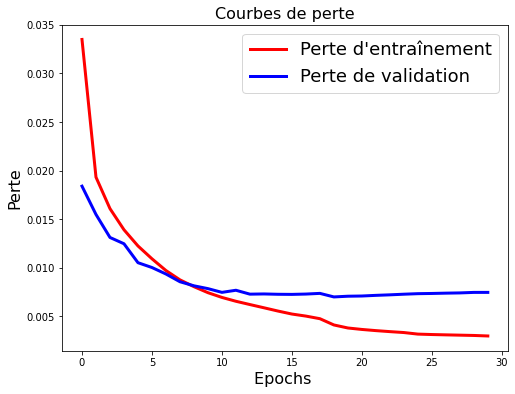

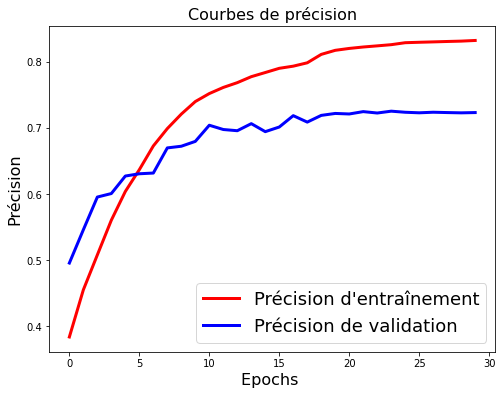

In [ ]:
# Courbes de perte
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(["Perte d'entraînement", "Perte de validation"],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Perte',fontsize=16)
plt.title('Courbes de perte',fontsize=16)
  
#Courbes de précision
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(["Précision d'entraînement", 'Précision de validation'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Précision',fontsize=16)
plt.title('Courbes de précision',fontsize=16)

In [ ]:
#Affichage des image de test en couleur, noir et blanc et colorisé
def ploot(color,grayscale,colorized):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('original photo', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale, cmap='gray')

    plt.subplot(1,3,3)
    plt.title('colorized ', color = 'blue', fontsize = 20)
    plt.imshow(colorized)
    plt.show()

In [ ]:
for i in range(0,19):
      #on fait un squeeze pour supprimer le canal unidimensionnel pour l'affichage des images N/B
     ploot(test_color_image[i],np.squeeze(test_gray_image[i]),x_decoded[i])